Translate review-level sentiment predictions into product-level insights to identify bestselling products, underperforming products, and actionable improvement areas.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Text preprocessing

In [24]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def make_clean_text(df):
    df = df.copy()   # <- IMPORTANT
    df['title'] = df['title'].fillna('')
    df['text'] = df['title'] + ' ' + df['reviews']
    df['clean_text'] = (
        df['text']
        .astype(str)
        .str.lower()
        .str.replace(r'[^a-z\s]', '', regex=True)
        .apply(lambda x: ' '.join(
            lemmatizer.lemmatize(w)
            for w in x.split()
            if w not in stop_words
        ))
    )
    return df


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Load data

In [25]:
df = pd.read_csv('/content/drive/MyDrive/target_project/data/clean_reviews.csv')
df = make_clean_text(df)
df.head()


,product,source,categories,date,didPurchase,doRecommend,rating,reviews,title,sentiment,review_length,text,clean_text
0,electronics brand product name Tablet A 10.1 T...,Target,"Electronics,iPad & Tablets,All Tablets,XYZ bra...",2021-01-13T00:00:00.000Z,NaN,1.0,5.0,This product so far has not disappointed. My c...,brand name,1,27,brand name This product so far has not disappo...,brand name product far disappointed child love...
1,electronics brand product name Tablet A 10.1 T...,Target,"Electronics,iPad & Tablets,All Tablets,XYZ bra...",2021-01-13T00:00:00.000Z,NaN,1.0,5.0,great for beginner or experienced person. Boug...,very fast,1,14,very fast great for beginner or experienced pe...,fast great beginner experienced person bought ...
2,electronics brand product name Tablet A 10.1 T...,Target,"Electronics,iPad & Tablets,All Tablets,XYZ bra...",2021-01-13T00:00:00.000Z,NaN,1.0,5.0,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,1,27,Beginner tablet for our 9 year old son. Inexpe...,beginner tablet year old son inexpensive table...
3,electronics brand product name Tablet A 10.1 T...,Target,"Electronics,iPad & Tablets,All Tablets,XYZ bra...",2021-01-13T00:00:00.000Z,NaN,1.0,4.0,I've had my XYZ brand HD 8 two weeks now and I...,Good!!!,1,119,Good!!! I've had my XYZ brand HD 8 two weeks n...,good ive xyz brand hd two week love tablet gre...
4,electronics brand product name Tablet A 10.1 T...,Target,"Electronics,iPad & Tablets,All Tablets,XYZ bra...",2021-01-12T00:00:00.000Z,NaN,1.0,5.0,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,1,117,Fantastic Tablet for kids I bought this for my...,fantastic tablet kid bought grand daughter com...


In [26]:
assert 'clean_text' in df.columns
df[['reviews', 'clean_text']].head()


,reviews,clean_text
0,This product so far has not disappointed. My c...,brand name product far disappointed child love...
1,great for beginner or experienced person. Boug...,fast great beginner experienced person bought ...
2,Inexpensive tablet for him to use and learn on...,beginner tablet year old son inexpensive table...
3,I've had my XYZ brand HD 8 two weeks now and I...,good ive xyz brand hd two week love tablet gre...
4,I bought this for my grand daughter when she c...,fantastic tablet kid bought grand daughter com...


Load trained model and vectorizer

In [27]:
import joblib

model = joblib.load('/content/drive/MyDrive/target_project/model_sentiment.pkl')
tfidf = joblib.load('/content/drive/MyDrive/target_project/tfidf_vectorizer.pkl')


Generate sentiment predictions for all reviews

In [28]:
X_all = tfidf.transform(df['clean_text'])
df['predicted_sentiment'] = model.predict(X_all)


In [29]:
df['predicted_sentiment'].value_counts(normalize=True)


,proportion
predicted_sentiment,
1,0.854614
0,0.145386


Product level aggregation

In [30]:
product_metrics = (
    df.groupby(['product', 'categories'])
    .agg(
        total_reviews=('predicted_sentiment', 'count'),
        positive_ratio=('predicted_sentiment', 'mean'),
        avg_rating=('rating', 'mean')
    )
    .reset_index()
)


In [31]:
product_metrics['bestseller_score'] = (
    product_metrics['total_reviews'] * product_metrics['positive_ratio']
)


Bestselling products per category

In [32]:
top_products = (
    product_metrics
    .sort_values('bestseller_score', ascending=False)
    .groupby('categories')
    .head(3)
)


In [33]:
top_products[['categories','product','total_reviews','positive_ratio']]


,categories,product,total_reviews,positive_ratio
38,"XYZ brand Tablets,Tablets,Computers & Tablets,...","XYZ brand Tablet, 7 Display, Wi-Fi, 8 GB - Inc...",10750,0.808000
81,"Walmart for Business,Office Electronics,Tablet...",retail brand brand name Paperwhite - eBook rea...,2928,0.929303
52,"Electronics,iPad & Tablets,All Tablets,XYZ bra...",electronics brand product name Tablet A 10.1 T...,2814,0.853589
76,"Stereos,Remote Controls,retail brand Echo,Audi...","retail brand XYZ brand Tv,,,_x000D_\nretail br...",2526,0.892716
51,"Stereos,Remote Controls,Target Echo,Audio Dock...",electonics brand Home_x000D_\nelectonics brand...,2100,0.902381
28,"Tablets,XYZ brand Tablets,Computers & Tablets,...","XYZ brand Kids Edition Tablet, 7 Display, Wi-F...",1437,0.813500
3,"Stereos,Remote Controls,Target Echo,Audio Dock...",\nelectonics brand Home,798,0.883459
9,"Computers/Tablets & Networking,Tablets & eBook...",Brand New electronics brand IPad16gb 7 Ips Dis...,793,0.820933
45,"Walmart for Business,Office Electronics,Tablet...","brand name Voyage E-reader, 6 High-Resolution ...",332,0.912651
66,"Stereos,Remote Controls,retail brand Echo,Audi...",retail brand Tap Portable Bluetooth and Wi-Fi ...,317,0.911672


Visualization

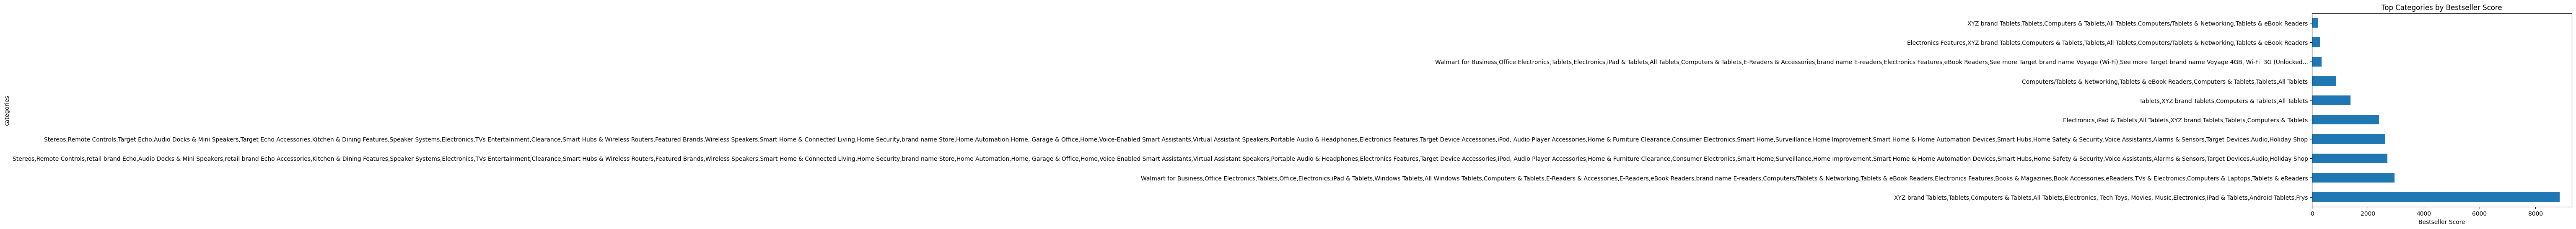

In [34]:
top_categories = (
    product_metrics
    .groupby('categories')['bestseller_score']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

top_categories.plot(kind='barh', figsize=(8,6))
plt.title('Top Categories by Bestseller Score')
plt.xlabel('Bestseller Score')
plt.show()


Identifying Underperforming products

In [39]:
problem_products = product_metrics[
    (product_metrics['total_reviews'] >= 10) &
    (product_metrics['positive_ratio'] < 0.6)
]


In [40]:
neg_reviews = df[df['predicted_sentiment'] == 0]
len(neg_reviews)


5034

Extracting common complaint themes

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(
    stop_words='english',
    min_df=20,
    max_features=15
)

X_neg = cv.fit_transform(neg_reviews['reviews'])
complaints = cv.get_feature_names_out()
complaints


array(['app', 'apps', 'bought', 'brand', 'don', 'good', 'great', 'just',
       'like', 'price', 'screen', 'tablet', 'target', 'use', 'xyz'],
      dtype=object)

In [42]:
top_products.to_csv('/content/drive/MyDrive/target_project/bestsellers_by_category.csv', index=False)
problem_products.to_csv('/content/drive/MyDrive/target_project/problem_products.csv', index=False)
